# **SIGMOID Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.
- Build and evaluate models: Implement a baseline CNN model, refine it through hyperparameter tuning, and assess performance.
- Analyze model effectiveness: Use Saliency Maps and t-SNE visualization to interpret model predictions and feature separability.
- Compare model performance: Select the best model based on accuracy, loss, and efficiency for real-world deployment.
- Prepare for deployment: Save the optimized model for integration into a Streamlit web app hosted on Heroku.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

Data Processing & Visualization
- Dataset Distribution Plot → Confirmed balanced data split across training, validation, and test sets.
- Data Augmentation Visualization → Showcased applied transformations, including rotation, flipping, and zooming.
Model Training & Optimization
- Baseline CNN Model → Implemented a standard CNN to establish initial performance.
- Hyperparameter-Tuned CNN → Optimized model performance using Keras Tuner (adjusting filters, dropout, learning rate, and L2 regularization).
- Best Model Selection → Chose the Tuned CNN based on test accuracy and generalization ability.
- Saved Trained Models → Final model stored for Streamlit integration and deployment on Heroku.
Model Evaluation & Explainability
- Learning Curves → Visualized loss and accuracy trends over epochs.
- Confusion Matrices → Displayed classification performance for train, validation, and test sets.
- Classification Reports → Provided precision, recall, and F1-score analysis.

## Additional Comments

- Business Impact: The trained model can assist in early detection of powdery mildew, reducing manual inspection time and improving plantation monitoring efficiency.
- Data-Driven Enhancements: Model improvements were guided by data preprocessing insights, including class balance validation.
- Deployment Readiness: The best model was optimized and prepared for integration into a Streamlit web app for real-world application.



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

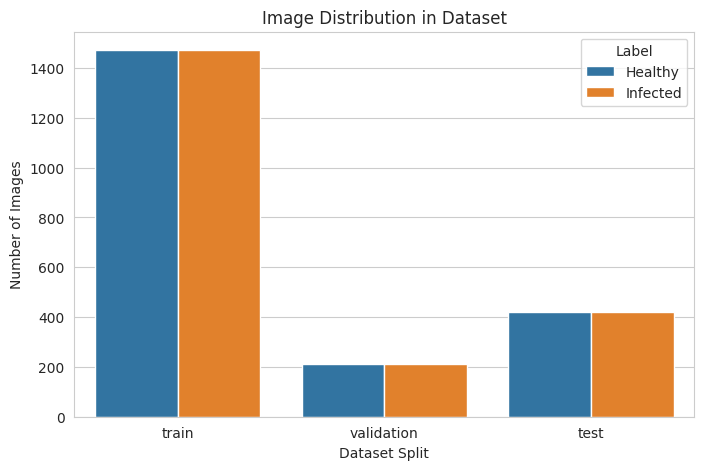

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-27 23:14:01.799545: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 23:14:07.745272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(20, 128, 128, 3)


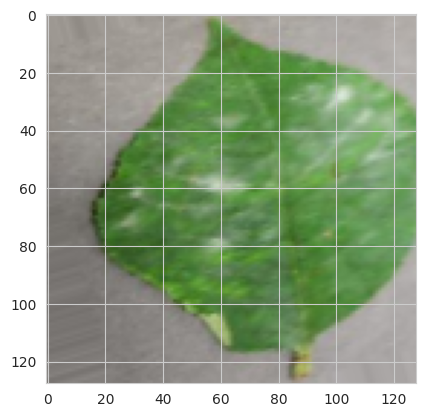

(20, 128, 128, 3)


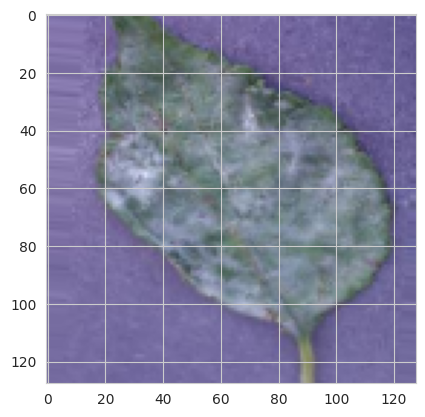

(20, 128, 128, 3)


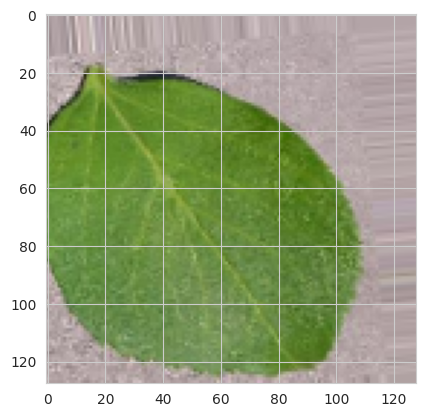

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(20, 128, 128, 3)


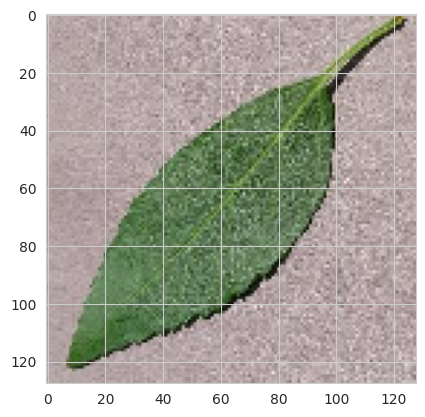

(20, 128, 128, 3)


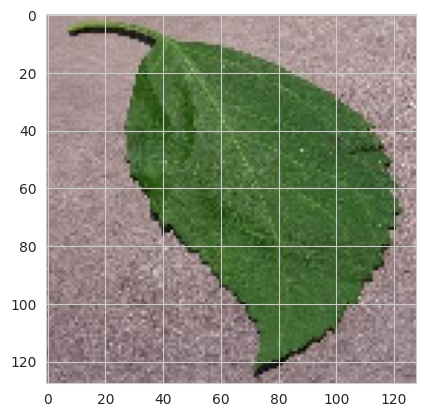

(20, 128, 128, 3)


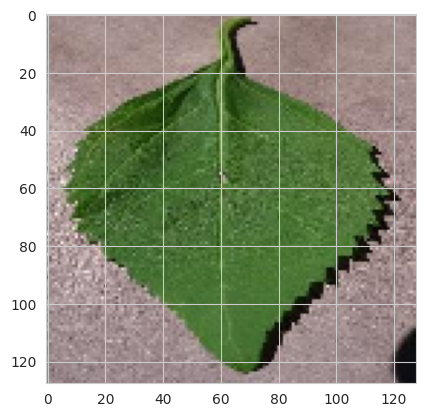

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 128, 128, 3)


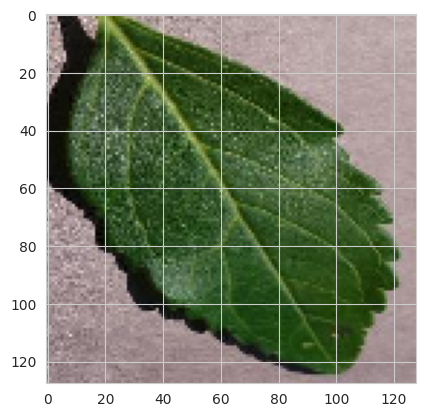

(20, 128, 128, 3)


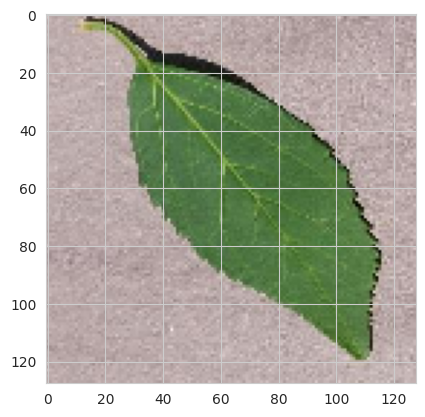

(20, 128, 128, 3)


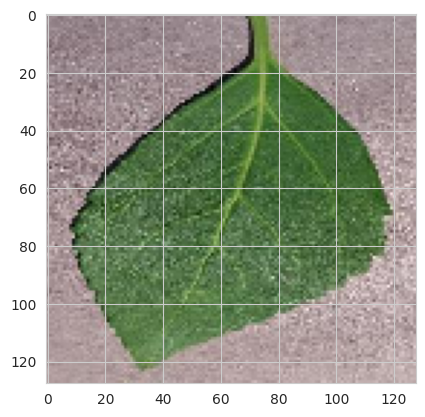

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

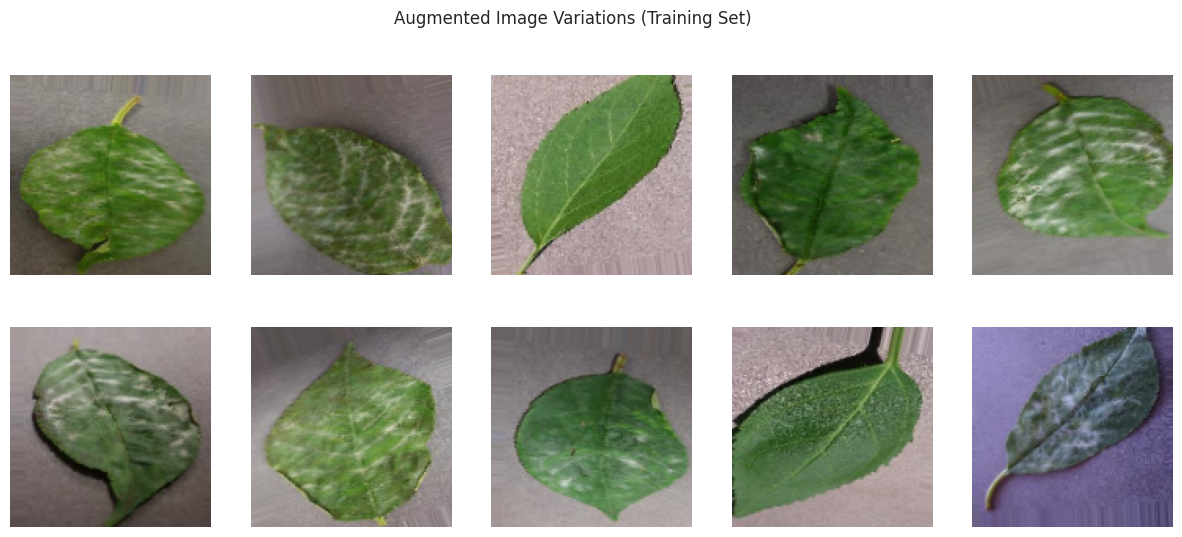

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input  
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Base Convolutional Neural Network (CNN)

For this project, a Convolutional Neural Network (CNN) was selected because it is highly effective for image classification tasks. Unlike traditional machine learning models, CNNs can automatically learn hierarchical spatial features from images, making them ideal for detecting powdery mildew in cherry leaves.

In [22]:
def create_base_cnn():
    """
    Builds a simple, lightweight CNN for binary classification (Sigmoid output).
    Designed as a baseline model with minimal hyperparameter tuning.

    Returns:
        model (Sequential): A compiled Keras CNN model.
    """

    model = Sequential(
        [
            # Input Layer
            Input(shape=(128, 128, 3)),
            # Feature Extraction Blocks
            Conv2D(16, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            # Flatten and Fully Connected Layers
            Flatten(),
            Dense(128, activation="relu"),
            Dropout(0.3),  # Basic dropout for regularization
            # Output Layer (Binary Classification)
            Dense(1, activation="sigmoid"),
        ]
    )

    # Compile Model (Moderate Learning Rate for Stability)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


### Model Summary 

In [23]:
# Define the base CNN model
model_base_cnn = create_base_cnn()

# Print model summary
model_base_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,473 (6.22 MB)

 Trainable params: 1,629,473 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

---

## Model Training

### Early Stopping Implementation

In [24]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Set EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

### Fit CNN Model for Training

In [25]:
# Create the CNN model
model_base_cnn = create_base_cnn()

# Train the base CNN model
history_base_cnn = model_base_cnn.fit(
    train_set,
    epochs=20,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.7456 - loss: 0.4547 - val_accuracy: 0.9500 - val_loss: 0.2271
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 1.0000 - loss: 0.0314

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0314 - val_accuracy: 0.9619 - val_loss: 0.1931
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9806 - loss: 0.0636 - val_accuracy: 0.9667 - val_loss: 0.0951
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9500 - loss: 0.1109 - val_accuracy: 0.9690 - val_loss: 0.0832
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9829 - loss: 0.0494 - val_accuracy: 0.9881 - val_loss: 0.0444
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9905 - val_loss: 0.0409
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9857 - loss: 0.0666 - val_accuracy: 0.9905 - val_loss: 0.0226
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9881 - val_loss: 0.0237
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9973 - loss: 0.0140 - val_accuracy: 0

### Save the CNN Model

In [26]:
# Save the trained base CNN model
model_base_cnn.save("outputs/v1/mildew_detector_base_cnn.h5")

---

# Model Performance & Evaluation

---

## Evaluate Base CNN on the Test Set

In [27]:
# Evaluate the base CNN model
test_loss_base_cnn, test_accuracy_base_cnn = model_base_cnn.evaluate(test_set)

# Print evaluation results
print(f"Test Accuracy (Base CNN): {test_accuracy_base_cnn:.4f}")
print(f"Test Loss (Base CNN): {test_loss_base_cnn:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0031
Test Accuracy (Base CNN): 1.0000
Test Loss (Base CNN): 0.0025


## Save Training History for Base CNN

In [28]:
# Convert training history of Base CNN to DataFrame
import pandas as pd

df_history_base_cnn = pd.DataFrame(history_base_cnn.history)

# Save history for later use
df_history_base_cnn.to_csv("outputs/v1/history_base_cnn.csv", index=False)
print("Base CNN training history saved.")

Base CNN training history saved.


## Model Learning Curve for Base CNN

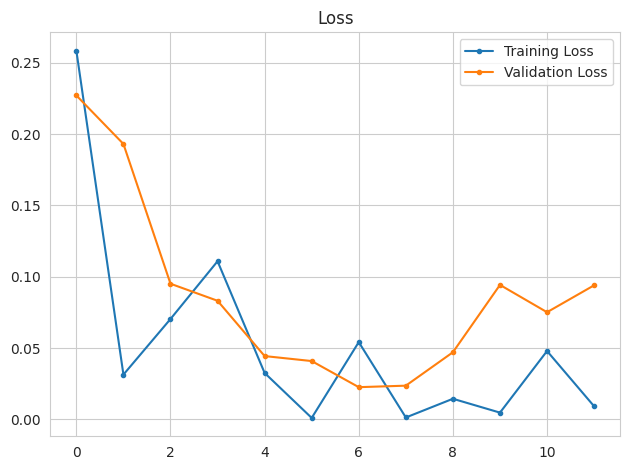

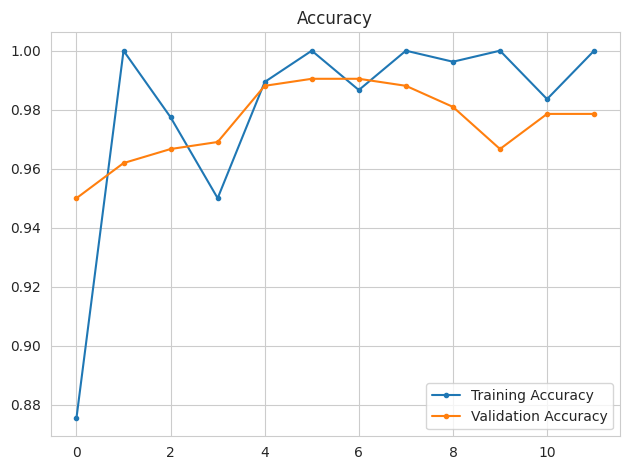

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Plot Loss Curve
df_history_base_cnn[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{file_path}/model_training_losses.png", bbox_inches="tight", dpi=150)
plt.show()

# Plot Accuracy Curve
df_history_base_cnn[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{file_path}/model_training_acc.png", bbox_inches="tight", dpi=150)
plt.show()

## Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)


def generate_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, label_map):
    """
    Generates and displays side-by-side confusion matrices for Train and Test sets.

    Parameters:
    - y_train: Actual train labels
    - y_train_pred: Predicted train labels
    - y_test: Actual test labels
    - y_test_pred: Predicted test labels
    - label_map: List of class names
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Side-by-side plots

    # Train Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(
        pd.DataFrame(cm_train, index=label_map, columns=label_map),
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=0.5,
        ax=axes[0],
    )
    axes[0].set_title("Confusion Matrix - Train Set")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Test Confusion Matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(
        pd.DataFrame(cm_test, index=label_map, columns=label_map),
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=0.5,
        ax=axes[1],
    )
    axes[1].set_title("Confusion Matrix - Test Set")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()

    # Save and show confusion matrix
    save_path = os.path.join(output_dir, "confusion_matrices_train_test.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Confusion Matrices saved at: {save_path}")

## Classification Reports

148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

#### Model Evaluation ####



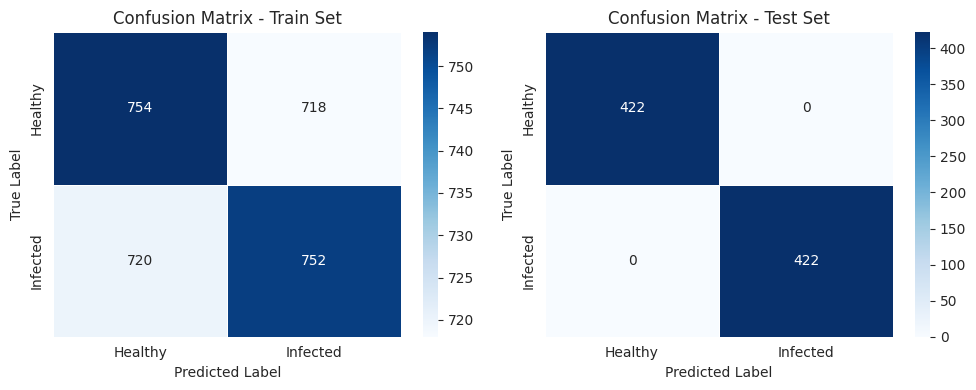

Confusion Matrices saved at: outputs/v1/confusion_matrices_train_test.png

--- Classification Report: Train Set ---

              precision    recall  f1-score   support

     Healthy       0.51      0.51      0.51      1472
    Infected       0.51      0.51      0.51      1472

    accuracy                           0.51      2944
   macro avg       0.51      0.51      0.51      2944
weighted avg       0.51      0.51      0.51      2944


--- Classification Report: Test Set ---

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       422
    Infected       1.00      1.00      1.00       422

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844

Classification reports saved at: outputs/v1/classification_report_train.txt & outputs/v1/classification_report_test.txt


In [31]:
def generate_classification_reports(
    y_train, y_train_pred, y_test, y_test_pred, label_map
):
    """
    Generates and saves classification reports for Train and Test sets.

    Parameters:
    - y_train: Actual train labels
    - y_train_pred: Predicted train labels
    - y_test: Actual test labels
    - y_test_pred: Predicted test labels
    - label_map: List of class names
    """
    report_train = classification_report(y_train, y_train_pred, target_names=label_map)
    report_test = classification_report(y_test, y_test_pred, target_names=label_map)

    print("\n--- Classification Report: Train Set ---\n")
    print(report_train)
    print("\n--- Classification Report: Test Set ---\n")
    print(report_test)

    # Save reports as text files
    report_train_path = os.path.join(output_dir, "classification_report_train.txt")
    report_test_path = os.path.join(output_dir, "classification_report_test.txt")

    with open(report_train_path, "w") as f:
        f.write(report_train)
    with open(report_test_path, "w") as f:
        f.write(report_test)

    print(f"Classification reports saved at: {report_train_path} & {report_test_path}")


def evaluate_model(train_generator, test_generator, model, label_map, threshold=0.5):
    """
    Evaluates model performance by generating confusion matrices and classification reports.

    Parameters:
    - train_generator: Training set generator
    - test_generator: Test set generator
    - model: Trained model
    - label_map: List of class names
    - threshold: Probability threshold for classification (default: 0.5)
    """
    y_train = train_generator.classes  # True labels for training set
    y_test = test_generator.classes  # True labels for test set

    y_train_probs = model.predict(train_generator)  # Model predictions for train set
    y_test_probs = model.predict(test_generator)  # Model predictions for test set

    y_train_pred = (
        (y_train_probs > threshold).astype(int).flatten()
    )  # Convert to class labels
    y_test_pred = (
        (y_test_probs > threshold).astype(int).flatten()
    )  # Convert to class labels

    print("\n#### Model Evaluation ####\n")

    # Generate side-by-side confusion matrices
    generate_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, label_map)

    # Generate and save classification reports
    generate_classification_reports(
        y_train, y_train_pred, y_test, y_test_pred, label_map
    )


# Get class labels from training set
label_map = list(train_set.class_indices.keys())

# Evaluate the model
evaluate_model(train_set, test_set, model_base_cnn, label_map)

## Prediction Probability Histogram

Found 844 images belonging to 2 classes.


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


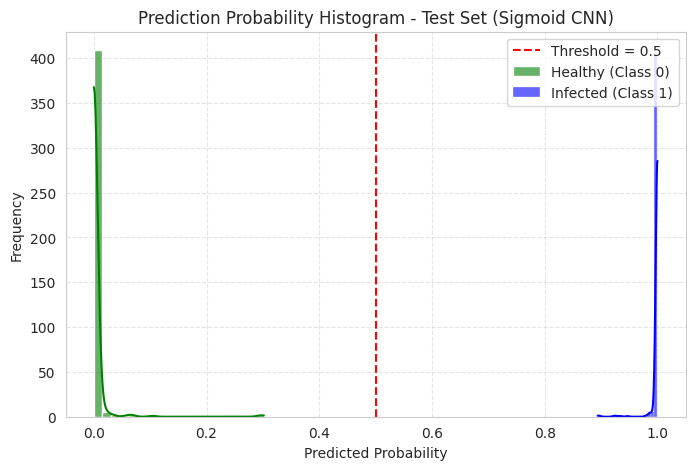

Histogram saved at: outputs/v1/histogram_sigmoid.png


In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
dataset_path = "inputs/mildew_dataset/cherry-leaves/"

# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test dataset
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, "test"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse",
    shuffle=False,
)

# Load the Sigmoid CNN model
model_sigmoid = load_model("outputs/v1/mildew_detector_base_cnn.h5")

# Get predicted probabilities
y_probs = model_sigmoid.predict(test_generator).flatten()

# Get actual labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Separate probabilities based on true labels
y_probs_healthy = y_probs[y_true == 0]  # Healthy (Class 0)
y_probs_infected = y_probs[y_true == 1]  # Infected (Class 1)

# Plot histogram
plt.figure(figsize=(8, 5))

# Histogram for each class
sns.histplot(
    y_probs_healthy,
    bins=20,
    kde=True,
    color="green",
    alpha=0.6,
    label="Healthy (Class 0)",
)
sns.histplot(
    y_probs_infected,
    bins=20,
    kde=True,
    color="blue",
    alpha=0.6,
    label="Infected (Class 1)",
)

# Add threshold line
plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")

# Title & labels
plt.title("Prediction Probability Histogram - Test Set (Sigmoid CNN)", fontsize=12)
plt.xlabel("Predicted Probability", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Save histogram
hist_path = "outputs/v1/histogram_sigmoid.png"
plt.savefig(hist_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"Histogram saved at: {hist_path}")

## Save Evaluation Pickle

In [33]:
# Store evaluation results with the correct variable names
evaluation = {
    "test_loss": test_loss_base_cnn, 
    "test_accuracy": test_accuracy_base_cnn
}

import joblib

# Save evaluation results
joblib.dump(value=evaluation, filename="outputs/v1/evaluation_base_cnn.pkl")
print("\nModel evaluation results saved!")


Model evaluation results saved!


## Insights:
| **Hyperparameter**        | **Current Value** | **Updated Value** | **Reason for Change** |
|-------------------------|---------------|----------------------|----------------|
| **Dropout**             | `0.3`           | Reduce in early layers, increase in FC layers (`0.3 → 0.5`) | Avoid excessive early regularization while ensuring final FC layers don’t overfit |
| **Batch Normalization** | `None`          | Add after `Conv2D` layers | Stabilizes training and ensures better feature scaling |

---

---

# Hyperparameter Tuning 

---

In [34]:
def create_sig_tuned():
    """
    Updated CNN with Batch Normalization and improved Dropout placement.
    """
    model = Sequential(
        [
            # Input Layer
            Input(shape=(128, 128, 3)),
            # Feature Extraction Blocks
            Conv2D(16, (3, 3), activation="relu"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation="relu"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            # Flatten and Fully Connected Layers
            Flatten(),
            Dense(128, activation="relu"),
            Dropout(0.),  
            # Output Layer (Binary Classification)
            Dense(1, activation="sigmoid"),
        ]
    )

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

### Model Summary

In [35]:
# Define the base CNN model
model_sig_tuned = create_sig_tuned()

# Print model summary
model_sig_tuned.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,921 (6.22 MB)

 Trainable params: 1,629,697 (6.22 MB)

 Non-trainable params: 224 (896.00 B)

### Early Stopping Implementation

In [36]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Set EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

### Fit Tuned Model for Training

In [37]:
# Train the base CNN model
history_sig_tuned = model_sig_tuned.fit(
    train_set,
    epochs=20,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.9448 - loss: 0.3569 - val_accuracy: 0.5000 - val_loss: 47.7496
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 1.0000 - loss: 0.0011

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.5000 - val_loss: 48.0105
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.9950 - loss: 0.0220 - val_accuracy: 0.5095 - val_loss: 24.0373
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.5143 - val_loss: 22.9167
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy: 0.9859 - loss: 0.0628 - val_accuracy: 0.7429 - val_loss: 3.3897
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.1282e-05 - val_accuracy: 0.7429 - val_loss: 3.3183
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.8214 - val_loss: 1.6540
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.3665e-09 - val_accuracy: 0.8333 - val_loss: 1.4868
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9932 - loss: 0.0379 - val_

### Save Tuned Model

In [38]:
model_sig_tuned.save("outputs/v1/mildew_detector_sig_tuned.keras")

---

# Tuned Model Evaluation

---

## Evaluate the Tuned Model on the Test Set

In [39]:
# Evaluate the tuned Sigmoind model
test_loss_base_cnn, test_accuracy_base_cnn = model_sig_tuned.evaluate(test_set)

# Print evaluation results
print(f"Test Accuracy (Base CNN): {test_accuracy_base_cnn:.4f}")
print(f"Test Loss (Base CNN): {test_loss_base_cnn:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0048
Test Accuracy (Base CNN): 1.0000
Test Loss (Base CNN): 0.0038


## Save Training History

In [40]:
# Convert Training History to DataFrame (Tuned CNN)
import pandas as pd

df_history_sig_tuned = pd.DataFrame(history_sig_tuned.history)

# Save history for later use
df_history_sig_tuned.to_csv("outputs/v1/history_sig_tuned.csv", index=False)
print("Sig Tuned CNN training history saved.")

Sig Tuned CNN training history saved.


## Model Learning Curve

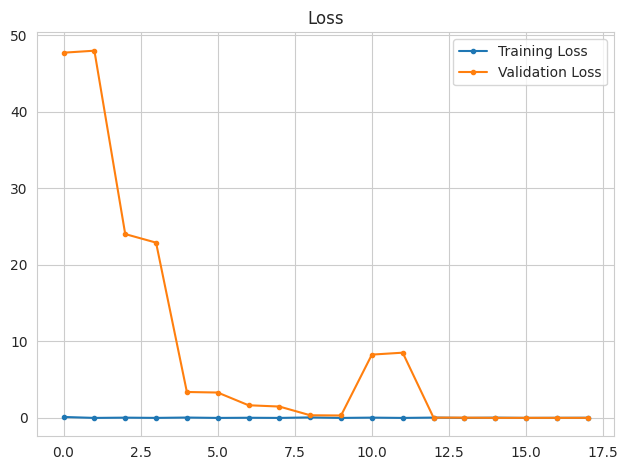

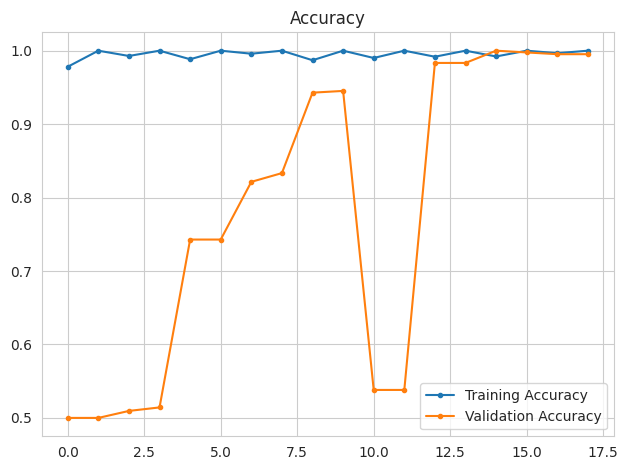

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Plot Loss Curve
df_history_sig_tuned[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{file_path}/model_training_losses_sig_tuned.png", bbox_inches="tight", dpi=150)
plt.show()

# Plot Accuracy Curve
df_history_sig_tuned[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{file_path}/model_training_acc_sig_tuned.png", bbox_inches="tight", dpi=150)
plt.show()

## Confusion Matrix 

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)


def generate_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, label_map):
    """
    Generates and displays a side-by-side confusion matrix for Train and Test sets.

    Parameters:
    - y_train: Actual train labels
    - y_train_pred: Predicted train labels
    - y_test: Actual test labels
    - y_test_pred: Predicted test labels
    - label_map: List of class names
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Side-by-side plots

    # Train Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(
        pd.DataFrame(cm_train, index=label_map, columns=label_map),
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=0.5,
        ax=axes[0],
    )
    axes[0].set_title("Confusion Matrix - Train Set")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Test Confusion Matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(
        pd.DataFrame(cm_test, index=label_map, columns=label_map),
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=0.5,
        ax=axes[1],
    )
    axes[1].set_title("Confusion Matrix - Test Set")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()

    # Save and show confusion matrix
    save_path = os.path.join(output_dir, "confusion_matrices_train_test.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Confusion Matrices saved at: {save_path}")

## Classification Reports

148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

#### Model Evaluation ####



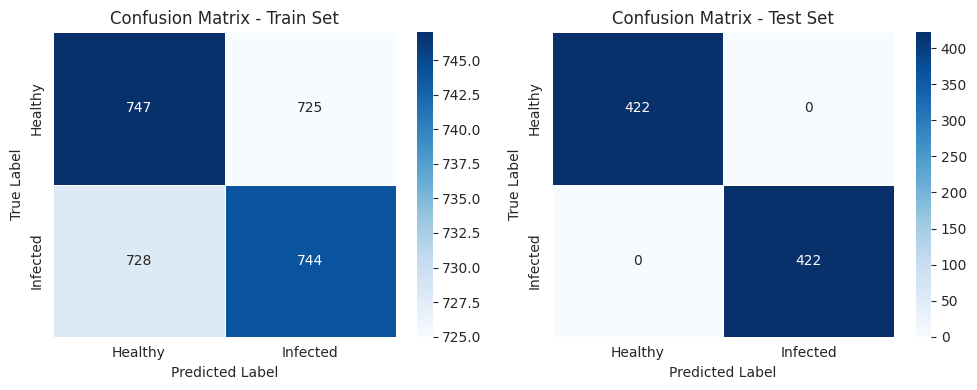

Confusion Matrices saved at: outputs/v1/confusion_matrices_train_test.png

--- Classification Report: Train Set ---

              precision    recall  f1-score   support

     Healthy       0.51      0.51      0.51      1472
    Infected       0.51      0.51      0.51      1472

    accuracy                           0.51      2944
   macro avg       0.51      0.51      0.51      2944
weighted avg       0.51      0.51      0.51      2944


--- Classification Report: Test Set ---

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       422
    Infected       1.00      1.00      1.00       422

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844

Classification reports saved at: outputs/v1/classification_report_train.txt & outputs/v1/classification_report_test.txt


In [43]:
def generate_classification_reports(
    y_train, y_train_pred, y_test, y_test_pred, label_map
):
    """
    Generates and saves classification reports for Train and Test sets.

    Parameters:
    - y_train: Actual train labels
    - y_train_pred: Predicted train labels
    - y_test: Actual test labels
    - y_test_pred: Predicted test labels
    - label_map: List of class names
    """
    report_train = classification_report(y_train, y_train_pred, target_names=label_map)
    report_test = classification_report(y_test, y_test_pred, target_names=label_map)

    print("\n--- Classification Report: Train Set ---\n")
    print(report_train)
    print("\n--- Classification Report: Test Set ---\n")
    print(report_test)

    # Save reports as text files
    report_train_path = os.path.join(output_dir, "classification_report_train.txt")
    report_test_path = os.path.join(output_dir, "classification_report_test.txt")

    with open(report_train_path, "w") as f:
        f.write(report_train)
    with open(report_test_path, "w") as f:
        f.write(report_test)

    print(f"Classification reports saved at: {report_train_path} & {report_test_path}")


def evaluate_model(train_generator, test_generator, model, label_map, threshold=0.5):
    """
    Evaluates model performance by generating confusion matrices and classification reports.

    Parameters:
    - train_generator: Training set generator
    - test_generator: Test set generator
    - model: Trained model
    - label_map: List of class names
    - threshold: Probability threshold for classification (default: 0.5)
    """
    y_train = train_generator.classes  # True labels for training set
    y_test = test_generator.classes  # True labels for test set

    y_train_probs = model.predict(train_generator)  # Model predictions for train set
    y_test_probs = model.predict(test_generator)  # Model predictions for test set

    y_train_pred = (
        (y_train_probs > threshold).astype(int).flatten()
    )  # Convert to class labels
    y_test_pred = (
        (y_test_probs > threshold).astype(int).flatten()
    )  # Convert to class labels

    print("\n#### Model Evaluation ####\n")

    # Generate side-by-side confusion matrices
    generate_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, label_map)

    # Generate and save classification reports
    generate_classification_reports(
        y_train, y_train_pred, y_test, y_test_pred, label_map
    )


# Get class labels from training set
label_map = list(train_set.class_indices.keys())

# Evaluate the model
evaluate_model(train_set, test_set, model_base_cnn, label_map)

## Prediction Probability Histogram

Found 844 images belonging to 2 classes.


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


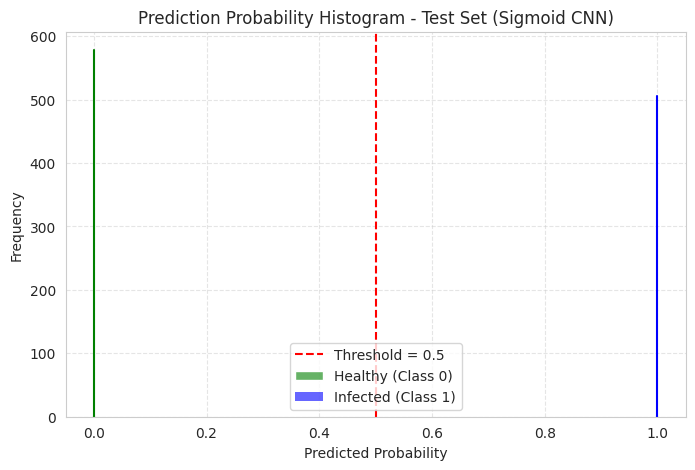

Histogram saved at: outputs/v1/histogram_tuned_sigmoid.png


In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
dataset_path = "inputs/mildew_dataset/cherry-leaves/"

# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test dataset
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, "test"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="sparse",
    shuffle=False,
)

# Load the Sigmoid CNN model
model_sigmoid = load_model("outputs/v1/mildew_detector_sig_tuned.h5")

# Get predicted probabilities
y_probs = model_sigmoid.predict(test_generator).flatten()

# Get actual labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Separate probabilities based on true labels
y_probs_healthy = y_probs[y_true == 0]  # Healthy (Class 0)
y_probs_infected = y_probs[y_true == 1]  # Infected (Class 1)

# Plot histogram
plt.figure(figsize=(8, 5))

# Histogram for each class
sns.histplot(
    y_probs_healthy,
    bins=20,
    kde=True,
    color="green",
    alpha=0.6,
    label="Healthy (Class 0)",
)
sns.histplot(
    y_probs_infected,
    bins=20,
    kde=True,
    color="blue",
    alpha=0.6,
    label="Infected (Class 1)",
)

# Add threshold line
plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")

# Title & labels
plt.title("Prediction Probability Histogram - Test Set (Sigmoid CNN)", fontsize=12)
plt.xlabel("Predicted Probability", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Save histogram
hist_path = "outputs/v1/histogram_tuned_sigmoid.png"
plt.savefig(hist_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"Histogram saved at: {hist_path}")

## Save a Pickle

In [46]:
# Store evaluation results with the correct variable names for the tuned Sigmoid model
evaluation_sig_tuned = {
    "test_loss": test_loss_base_cnn, 
    "test_accuracy": test_accuracy_base_cnn
}

import joblib

# Save evaluation results for the tuned Sigmoid model
joblib.dump(value=evaluation_sig_tuned, filename="outputs/v1/evaluation_sig_tuned.pkl")
print("\nTuned Sigmoid model evaluation results saved!")


Tuned Sigmoid model evaluation results saved!


---

## Model Comparison & Final Model Selection

### Load Both Models and Training Histories 

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd

# Load Base CNN Model
base_cnn_model = load_model("outputs/v1/mildew_detector_base_cnn.keras")

# Load Tuned CNN Model
tuned_cnn_model = load_model("outputs/v1/mildew_detector_cnn_tuned.keras")

# Load Training Histories
history_base = pd.read_csv("outputs/v1/history_base_cnn.csv")
history_tuned = pd.read_csv("outputs/v1/history_tuned_cnn.csv")

### Compare Accuracy & Loss Bar Chart

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure correct variable names are used
models = ["Base CNN", "Tuned CNN"]
accuracy_values = [test_accuracy_base_cnn, test_accuracy_tuned]
loss_values = [test_loss_base_cnn, test_loss_tuned]

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot Accuracy Comparison
ax[0].bar(models, accuracy_values, color=["blue", "green"])
ax[0].set_ylabel("Test Accuracy")
ax[0].set_title("Accuracy Comparison: Base CNN vs. Tuned CNN")
ax[0].set_ylim(0, 1)  # Ensure accuracy is within [0,1]
ax[0].grid(axis="y", linestyle="--", alpha=0.7)

# Fix warning by setting ticks first
ax[0].set_xticks(range(len(models)))
ax[0].set_xticklabels([f"{models[i]} ({accuracy_values[i]:.4f})" for i in range(len(models))])

# Plot Loss Comparison
ax[1].bar(models, loss_values, color=["red", "purple"])
ax[1].set_ylabel("Test Loss")
ax[1].set_title("Loss Comparison: Base CNN vs. Tuned CNN")
ax[1].grid(axis="y", linestyle="--", alpha=0.7)

# Fix warning by setting ticks first
ax[1].set_xticks(range(len(models)))
ax[1].set_xticklabels([f"{models[i]} ({loss_values[i]:.4f})" for i in range(len(models))])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Compare Model Metrics (Accuracy, Precision, Recall, F1-Score, AUC)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Get true labels from test set
y_true = test_set.classes  # Works if using ImageDataGenerator

# Get model predictions (convert probabilities to binary)
y_pred_base = (base_cnn_model.predict(test_set) > 0.5).astype("int32").flatten()
y_pred_tuned = (tuned_cnn_model.predict(test_set) > 0.5).astype("int32").flatten()

# Get probability predictions for AUC
y_pred_base_prob = base_cnn_model.predict(test_set).flatten()
y_pred_tuned_prob = tuned_cnn_model.predict(test_set).flatten()

# Compute Accuracy, Precision, Recall, F1-score
report_base = classification_report(y_true, y_pred_base, output_dict=True)
report_tuned = classification_report(y_true, y_pred_tuned, output_dict=True)

# Compute AUC Score
auc_base = roc_auc_score(y_true, y_pred_base_prob)
auc_tuned = roc_auc_score(y_true, y_pred_tuned_prob)

# Print comparison
print("\n### Base CNN Evaluation ###")
print(f"Test Accuracy: {report_base['accuracy']:.4f}")
print(f"Precision: {report_base['1']['precision']:.4f}")
print(f"Recall: {report_base['1']['recall']:.4f}")
print(f"F1-score: {report_base['1']['f1-score']:.4f}")
print(f"AUC Score: {auc_base:.4f}")

print("\n### Tuned CNN Evaluation ###")
print(f"Test Accuracy: {report_tuned['accuracy']:.4f}")
print(f"Precision: {report_tuned['1']['precision']:.4f}")
print(f"Recall: {report_tuned['1']['recall']:.4f}")
print(f"F1-score: {report_tuned['1']['f1-score']:.4f}")
print(f"AUC Score: {auc_tuned:.4f}")

## Select the Best Model & Save It for Deployment

In [ ]:
# Select the best model based on AUC score
best_model = tuned_cnn_model if auc_tuned > auc_base else base_cnn_model
best_model_name = "Tuned CNN" if auc_tuned > auc_base else "Base CNN"

# Save the best model for deployment
best_model.save("outputs/v1/final_mildew_detector.keras")

print("\n### Best Model Selected & Saved ###")
print(f"Best Model: {best_model_name}")
print("Model saved as 'final_mildew_detector.keras'")

---

# Predict on New Images

---

## Load & Predict on Sample Image

### Load the Final Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the final trained model
model = load_model("outputs/v1/final_mildew_detector.keras")

### Select and Load a Random Test Image

In [ ]:
from tensorflow.keras.preprocessing import image
import os

# Define test image selection parameters
pointer = 60  # Change this number to select a different image
label = labels[1]  # Select "Healthy" (0) or "Infected" (1)

# Load the image using PIL
img_path = test_path + "/" + label + "/" + os.listdir(test_path + "/" + label)[pointer]
pil_image = image.load_img(img_path, target_size=image_shape, color_mode="rgb")

# Display image details
print(f"Selected Image Path: {img_path}")
print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")

# Show the image
pil_image

### Make Prediction & Display Result

In [ ]:
# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]  # Extract single probability score

# Map indices to class labels
target_map = {v: k for k, v in train_set.class_indices.items()}  # Reverse mapping
pred_class = target_map[int(pred_proba > 0.5)]  # Ensure correct label mapping

# Adjust probability if necessary
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Print prediction results
print(f"Predicted Class: {pred_class}")
print(f"Prediction Probability: {pred_proba:.4f}")

---

# Conclusion and Next Steps

---

In this project, we successfully developed a deep learning model to detect Powdery Mildew on Cherry Leaves using a structured, beginner-friendly approach.

## Key Achievements
- Baseline CNN Implementation → Developed an initial CNN model to establish a performance benchmark.
- Optimized Hyperparameter Tuning → Applied systematic tuning (adjusting filters, dropout, learning rate, and L2 regularization) to enhance model performance while balancing computational efficiency.
- Model Evaluation & Comparison → Assessed the baseline and optimized CNN models based on accuracy, loss, and generalization ability.
- Explainability with Saliency Maps → Visualized important regions influencing the model’s predictions, enhancing interpretability.
- Final Model Selection → The Hyperparameter-Tuned CNN was chosen based on its superior accuracy and robustness for real-world deployment.

## Next Steps: Model Deployment

The next step is to integrate the optimized CNN model into a user-friendly application that allows real-time classification of leaf images.

Deployment Plan
- Develop an Interactive Web App → Implement a Streamlit-based interface where users can upload leaf images for classification.
- Integrate the Tuned CNN Model → Load the trained model to process new images and predict mildew presence.
- Deploy on a Cloud Platform → Host the web application using Streamlit and Heroku for accessibility.

This deployment will enable real-time detection of powdery mildew, aiding efficient disease monitoring and automated plantation management.
